# Tarea 2 - MAN3160

Alumnos: Juan David Bejarano y Sebastian Barrios



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, utilizaremos la librería Implicit vista en los tutoriales del curso para comparar el rendimiento de los modelos ALS y BPR.
Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

## Descarga del dataset

Al igual que en la tarea 1 y los tutoriales del curso, vamos a descargar el dataset [MovieLens-100k](https://grouplens.org/).

Podemos descargar el dataset directamente con el comando wget.

In [1]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip


Saved under ml-100k (7).zip


In [2]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time

In [4]:
train_dir = "ml-100k/u3.base"
test_dir = "ml-100k/u3.test"

In [5]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


In [6]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Funciones

In [7]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [8]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_map, mean_ndcg

In [9]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']

# Actividades

### Actividad 1: Preparación del dataset

Prepare el dataset para que este pueda ser utilizado por los algoritmos de la librería Implicit. (Puede utilizar de base los tutoriales del curso), hasta generar la matriz user_items en formato csr. Puede importar/utilizar cualquier librería adicional que desée.

#### Respuesta:

Ingrese su respuesta en código a continuación. Puede utilizar todas las celdas de código que estime necesaria. Al finalizar, añada una celda de texto (Markdown en Jupyter) explicando qué contiene la matriz csr generada, qué representan sus columnas, sus filas y sus celdas internas.

### 1.1. Transformación del DataSet a feedback Implícito

En primer lugar, convertimos el rating (feedback explícito) a un criterio de relevante o no relevante (1 o 0) dependiendo de si el feedback es mayor o igual a 3.

In [10]:
# Primero creamos el dataframe de entrenamiento
df_train = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

# Así mismo, creamos el df de test

df_test = pd.read_csv(test_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

In [11]:
# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]

1.2 Preprocesamiento de los datos a formato Sparce

In [12]:
#Para el set de entrenamiento
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

user_item_matrix = sparse.csr_matrix(sparse_matrix)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
items_ids = {key: i for i, key in enumerate(itemset)}

In [13]:
#Para el set de test
user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

Convertimos el training set en un formato Sparce que requiere menos memoria que la matriz densa y puede ser más rápida de calcular. Así mismo, creamos la matriz user items para el test set.

La matriz generada contiene las siguientes caracteristicas:

-La matriz tiene 943 filas, que representan usuarios, y 1650 columnas, que representan elementos.

-La matriz contiene un total de 80,000 elementos almacenados. Esto significa que hay 80,000 interacciones de usuarios con elementos en su conjunto de datos. La matriz está almacenada en formato CSR (Compressed Sparse Row), que es una forma eficiente de representar matrices dispersas.

### Actividad 2: Entrenamiento de modelo ALS

Entrene el modelo ALS con el set de entrenamiento y realice un estudio de hiperparámetros sobre al menos 2 hiperparámetros del modelo. Despliegue el gráfico sobre la variación del rendimiento (en base a las métricas nDCG y MAP) según el valor del hiperparámetro y explique explícitamente la forma de los gráficos, las conclusiones obtenidas de ellos y la mejor combinación de hiperparámetros en su opinión. Registre y haga un gráfico del tiempo de entrenamiento de cada método. Se recomienda usar la librería _time_ para esto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

Los 2 hiperparámetros a optimizar serán el número de factores latentes y el factor de regularación. Para ellos utilizaremos valores de factores latentes de 5 en 5 empezando en 5 hasta 75. Los factores de regularización serán 0.001, 0.01, 0.1.

In [14]:
factores_list = [i * 5 for i in range(1, 15)]
regularization_factors = [0.001, 0.01, 0.05, 0.1]
map_scores = []
ndcg_scores = []
time_scores = []

map_regularization = []
ndcg_regularization = []
time_regularization = []

for factor in factores_list:
    start_time = time.time()
    als_model = implicit.als.AlternatingLeastSquares(factors=factor)
    als_model.fit(user_item_matrix)
    end_time = time.time()

    execution_time = end_time - start_time
    time_scores.append(execution_time)

    mean_map, ndcg = evaluate_model(als_model, 10)
    map_scores.append(mean_map)
    ndcg_scores.append(ndcg)

for reg_factor in regularization_factors:
    start_time = time.time()
    als_model = implicit.als.AlternatingLeastSquares(regularization=reg_factor)


    als_model.fit(user_item_matrix)
    end_time = time.time()

    execution_time = end_time - start_time
    time_regularization.append(execution_time)

    mean_map, ndcg = evaluate_model(als_model, 10)
    map_regularization.append(mean_map)
    ndcg_regularization.append(ndcg)

best_map_index = np.argmax(map_scores)
best_ndcg_index = np.argmax(ndcg_scores)
best_map_reg_index = np.argmax(map_regularization)
best_ndcg_reg_index = np.argmax(ndcg_regularization)

best_factors_value = factores_list[best_map_index]
best_reg_factor_value = regularization_factors[best_map_reg_index]

print("Mejor combinación de parámetros:")
print(f"Factores: {best_factors_value}")
print(f"Regularización: {best_reg_factor_value}")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Mejor combinación de parámetros:
Factores: 25
Regularización: 0.01


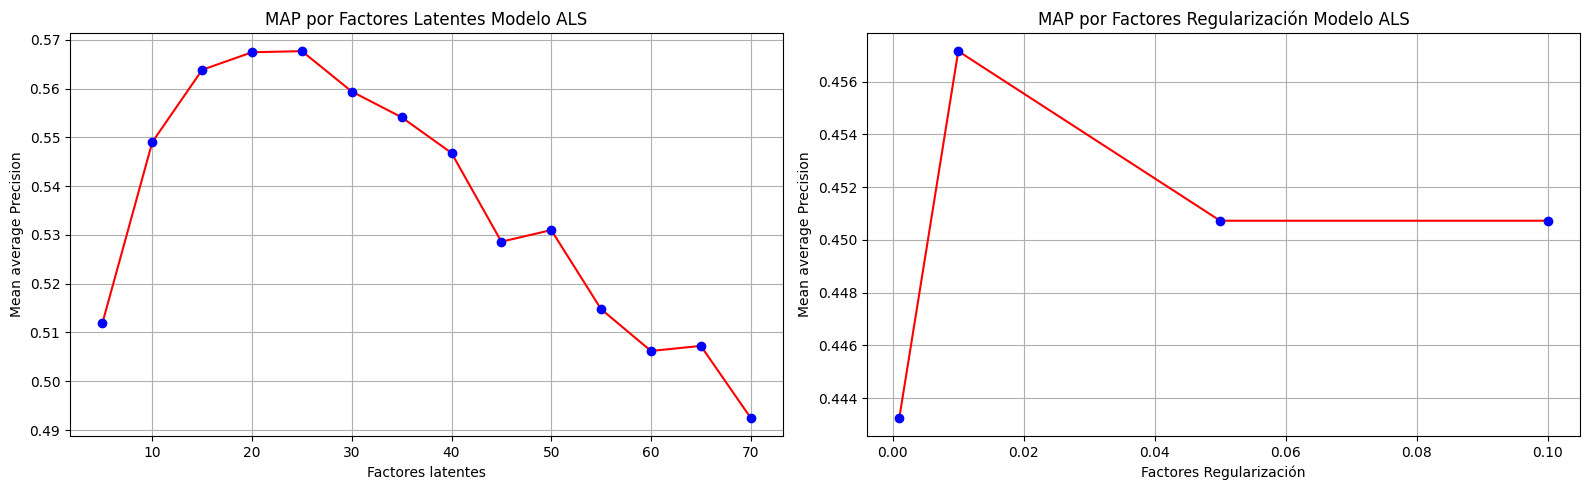

In [15]:
# Crear una figura con dos subplots en una fila y dos columnas
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # Ajusta el tamaño de la figura según tus preferencias

# Graficar el primer gráfico en el primer subplot
axs[0].plot(factores_list, map_scores, 'r-')
axs[0].plot(factores_list, map_scores, 'bo')
axs[0].set_xlabel('Factores latentes')
axs[0].set_ylabel('Mean average Precision')
axs[0].set_title('MAP por Factores Latentes Modelo ALS')
axs[0].grid(True)

# Graficar el segundo gráfico en el segundo subplot
axs[1].plot(regularization_factors, map_regularization, 'r-')
axs[1].plot(regularization_factors, map_regularization, 'bo')
axs[1].set_xlabel('Factores Regularización')
axs[1].set_ylabel('Mean average Precision')
axs[1].set_title('MAP por Factores Regularización Modelo ALS')
axs[1].grid(True)

# Ajustar el espacio entre los subplots para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con los dos gráficos
plt.show()

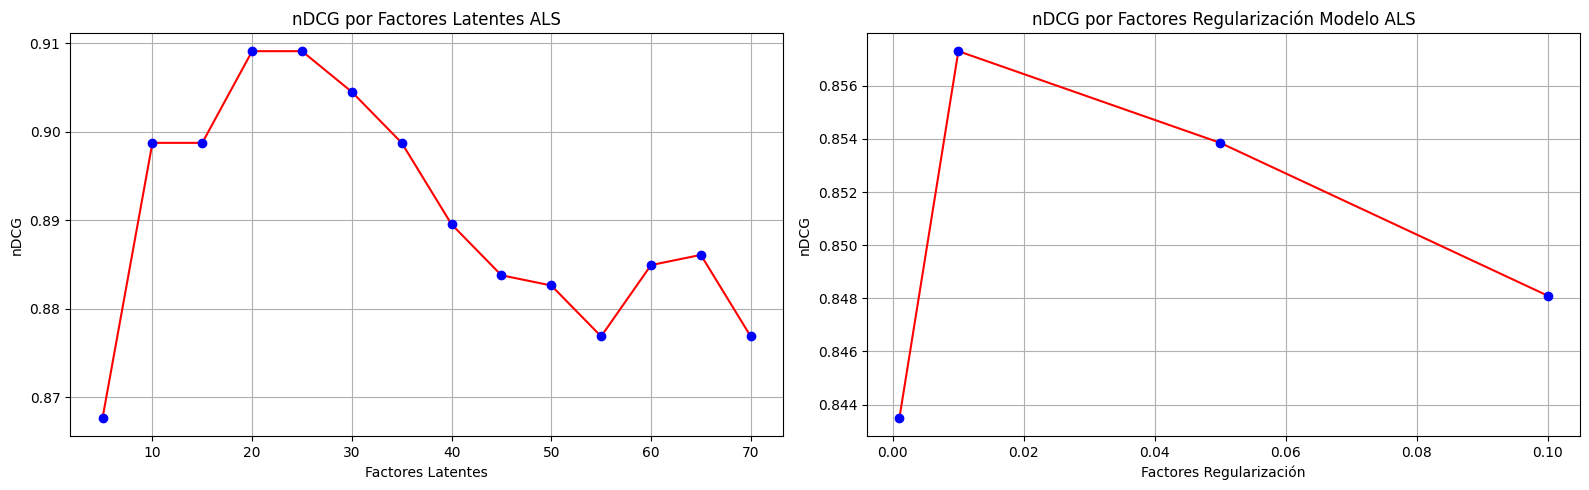

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # Ajusta el tamaño de la figura según tus preferencias

# Graficar el primer gráfico en el primer subplot
axs[0].plot(factores_list, ndcg_scores, 'r-')
axs[0].plot(factores_list, ndcg_scores, 'bo')
axs[0].set_xlabel('Factores Latentes')
axs[0].set_ylabel('nDCG')
axs[0].set_title('nDCG por Factores Latentes ALS')
axs[0].grid(True)

# Graficar el segundo gráfico en el segundo subplot
axs[1].plot(regularization_factors, ndcg_regularization, 'r-')
axs[1].plot(regularization_factors, ndcg_regularization, 'bo')
axs[1].set_xlabel('Factores Regularización')
axs[1].set_ylabel('nDCG')
axs[1].set_title('nDCG por Factores Regularización Modelo ALS')
axs[1].grid(True)

# Ajustar el espacio entre los subplots para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con los dos gráficos
plt.show()


Ahora, medimos el tiempo de entrenamiento de cada modelo dependiendo de la cantidad de factores latentes y del factor de regularización.

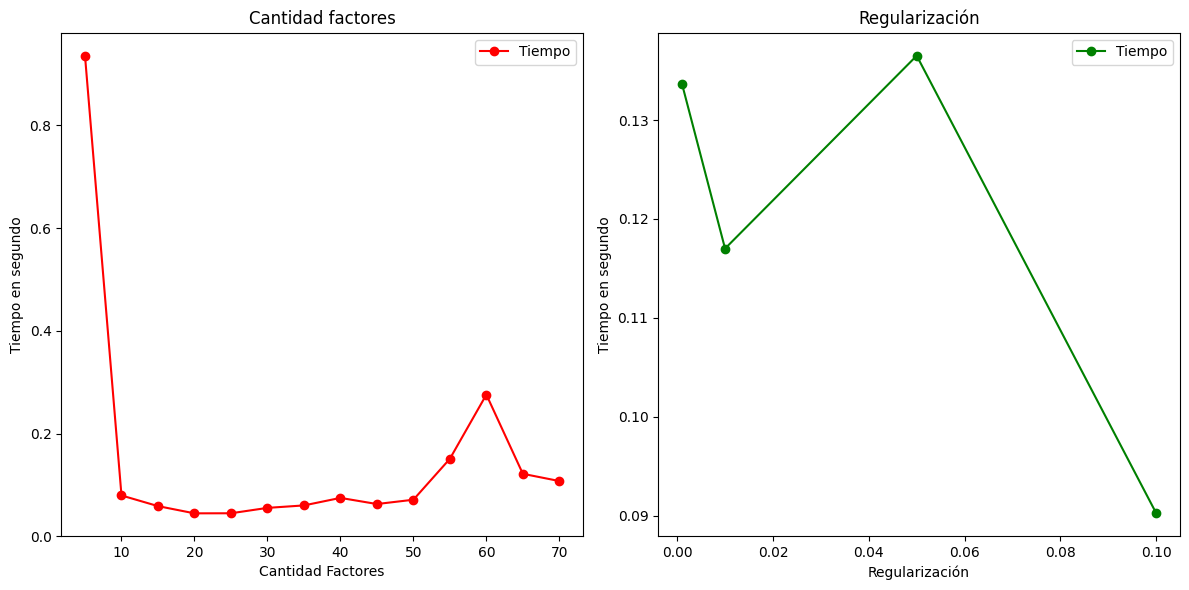

In [17]:
# TIEMPO DE EJECUCION
plt.figure(figsize=(12, 6))



plt.subplot(1, 2, 2)
plt.plot(regularization_factors, time_regularization, marker='o', linestyle='-', color='g', label='Tiempo')
plt.xlabel("Regularización")
plt.ylabel("Tiempo en segundo")
plt.title("Regularización")
plt.legend()

plt.subplot(1, 2, 1)
plt.plot(factores_list, time_scores, marker='o', linestyle='-', color='r', label='Tiempo')
plt.xlabel("Cantidad Factores")
plt.ylabel("Tiempo en segundo")
plt.title("Cantidad factores")
plt.legend()


plt.tight_layout()
plt.show()

**Explicación y selección de los hiperparámetros:**

La cantidad de factores latentes que maximiza tanto la métrica MAP como nDCG es 20. Así mismo, el factor de regularización que maximiza ambas métricas es 0.01.Por lo tanto, estos son los hiperparámetros que seleccionamos y que maximizan ambas métricas.

Las métricas de tiempo de ejecución pareciese que se demoraran en la primera iteracción, pero después se estabilizan.

### Actividad 3: Entrenamiento de modelo BPR

Repita el procedimiento de la Actividad 2 para el modelo BPR. Recuerde realizar un estudio de hiperparámetros sobre dos hiperparámetros distintos y exponer sus observaciones, elecciones como mejor combinación de hiperparámetros y realizar un análisis del tiempo de entrenamiento.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [18]:
learning_rate = [0.001 * i for i in range(1, 20)]
num_threads = [i*3 for i in range(1, 15)]

map_lr = []
ndcg_lr = []

map_num = []
ndcg_num = []

train_times_learn = []
train_times_num = []

for lr in learning_rate:
    start_time = time.time()
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(learning_rate=lr)
    model_bpr.fit(user_item_matrix)
    train_time = time.time() - start_time
    train_times_learn.append(train_time)
    mmap, ndcg = evaluate_model(model_bpr, 10)
    map_lr.append(mmap)
    ndcg_lr.append(ndcg)


for nm in num_threads:
    start_time = time.time()
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(num_threads=nm)
    model_bpr.fit(user_item_matrix)
    train_time = time.time() - start_time
    train_times_num.append(train_time)
    mmap, ndcg = evaluate_model(model_bpr, 10)
    map_num.append(mmap)
    ndcg_num.append(ndcg)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

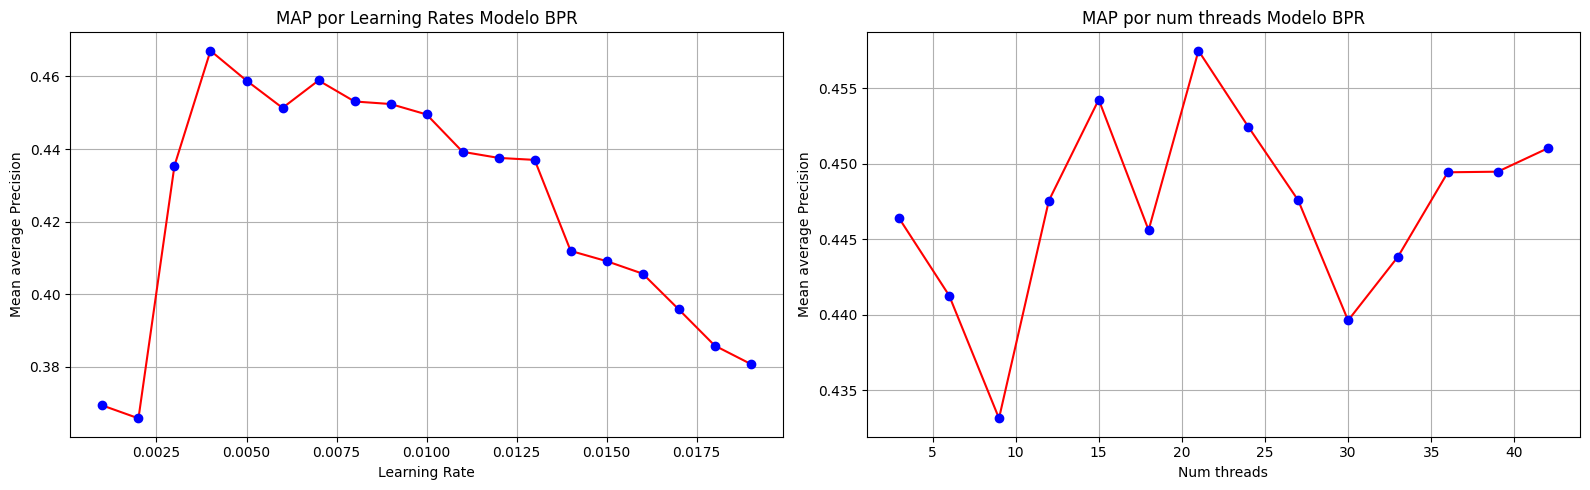

In [19]:
import matplotlib.pyplot as plt

# Crear una figura con dos subplots en una fila y dos columnas
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # Ajusta el tamaño de la figura según tus preferencias

# Graficar el primer gráfico en el primer subplot
axs[0].plot(learning_rate, map_lr, 'r-')
axs[0].plot(learning_rate, map_lr, 'bo')
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('Mean average Precision')
axs[0].set_title('MAP por Learning Rates Modelo BPR')
axs[0].grid(True)

# Graficar el segundo gráfico en el segundo subplot
axs[1].plot(num_threads, map_num, 'r-')
axs[1].plot(num_threads, map_num, 'bo')
axs[1].set_xlabel('Num threads')
axs[1].set_ylabel('Mean average Precision')
axs[1].set_title('MAP por num threads Modelo BPR')
axs[1].grid(True)

# Ajustar el espacio entre los subplots para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con los dos gráficos
plt.show()


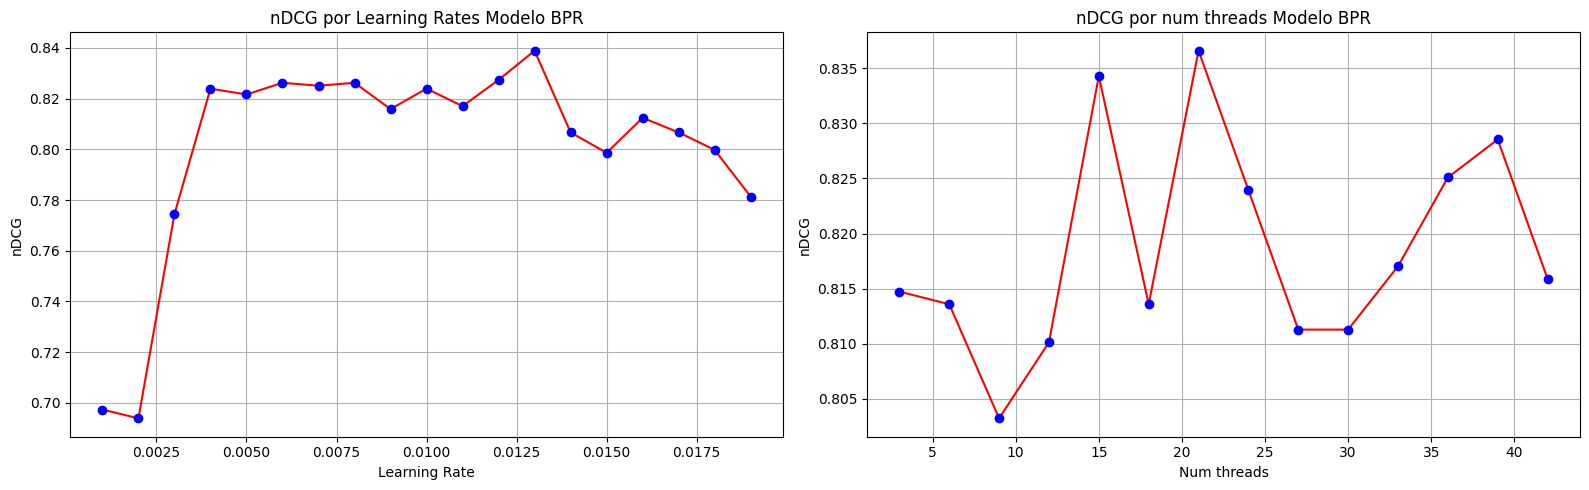

In [20]:
import matplotlib.pyplot as plt

# Crear una figura con dos subplots en una fila y dos columnas
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # Ajusta el tamaño de la figura según tus preferencias

# Graficar el primer gráfico en el primer subplot
axs[0].plot(learning_rate, ndcg_lr, 'r-')
axs[0].plot(learning_rate, ndcg_lr, 'bo')
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('nDCG')
axs[0].set_title('nDCG por Learning Rates Modelo BPR')
axs[0].grid(True)

# Graficar el segundo gráfico en el segundo subplot
axs[1].plot(num_threads, ndcg_num, 'r-')
axs[1].plot(num_threads, ndcg_num, 'bo')
axs[1].set_xlabel('Num threads')
axs[1].set_ylabel('nDCG')
axs[1].set_title('nDCG por num threads Modelo BPR')
axs[1].grid(True)

# Ajustar el espacio entre los subplots para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con los dos gráficos
plt.show()


Ahora, medimos el tiempo de entrenamiento de cada modelo a partir de los learning rates propuestos y del número de threads.

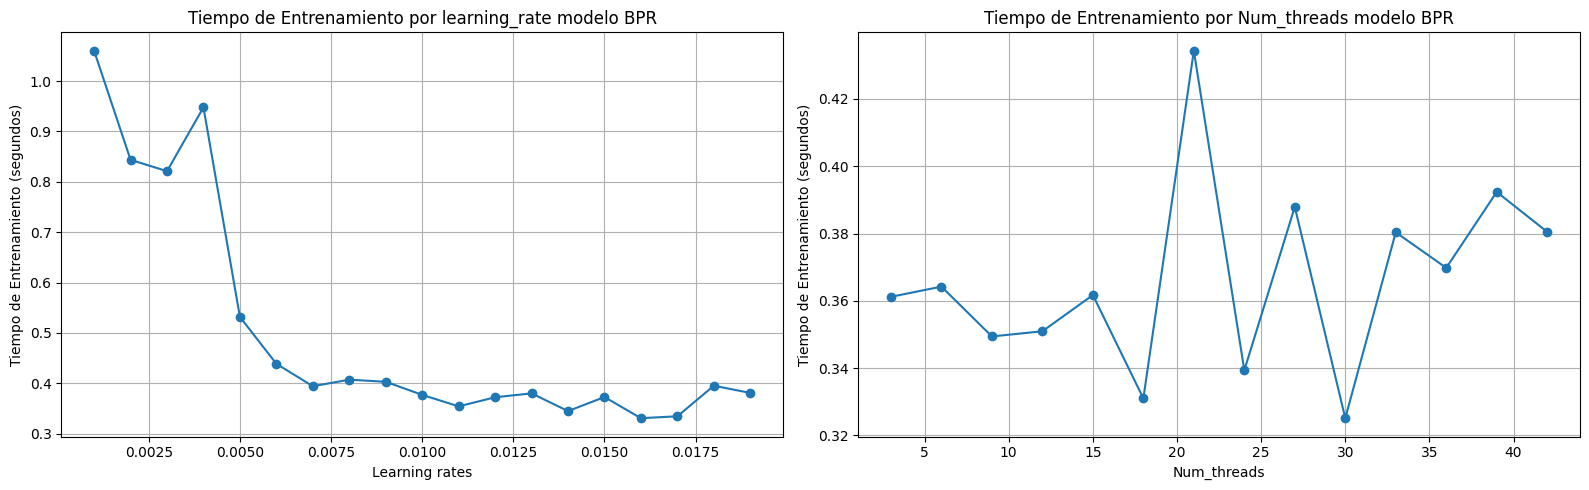

In [21]:
import matplotlib.pyplot as plt

# Crear una figura con dos subplots en una fila y dos columnas
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # Ajusta el tamaño de la figura según tus preferencias

# Graficar el primer gráfico en el primer subplot
axs[0].plot(learning_rate, train_times_learn, marker='o')
axs[0].set_xlabel('Learning rates')
axs[0].set_ylabel('Tiempo de Entrenamiento (segundos)')
axs[0].set_title('Tiempo de Entrenamiento por learning_rate modelo BPR')
axs[0].grid(True)

# Graficar el segundo gráfico en el segundo subplot
axs[1].plot(num_threads, train_times_num, marker='o')
axs[1].set_xlabel('Num_threads')
axs[1].set_ylabel('Tiempo de Entrenamiento (segundos)')
axs[1].set_title('Tiempo de Entrenamiento por Num_threads modelo BPR')
axs[1].grid(True)

# Ajustar el espacio entre los subplots para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con los dos gráficos
plt.show()


**Explicación y selección de los hiperparámetros:**

A partir de estos resultados, vemos que el learning rate que maximiza el valor del MAP es 0.004. Si bien no es el hiperparámetro más alto en la métrica nDCG, también tiene un buen resultado en dicha gráfica. El número de threads que máxima ambas métricas es el 21. Por lo tengo, escogemos estos 2 hiperparámetros como los que maximizan las métricas de desempeño.

Volvemos a observar que pareciese que el tiempo de ejecución del entrenamiento empieza un poco más lento, pero luego se acelera y se estabiliza un poco.

### Actividad 4: Comparación de modelos.

Entrene modelos ALS y BPR con la combinación de hiperparámetros seleccionadas de las actividades 2 y 3. Genere una tabla exponiendo los resultados de ambos modelos al evaluarlos según nDCG@k y MAP@k proporcionadas (son libres de elegir el valor de k). Incluya también el valor del tiempo de entrenamiento empleado.

Además, implemente y agregue a su tabla los resultados usando una métrica adicional estudiada en el curso. Esta métrica puede ser programada por ustedes o usando una función de una librería externa.

Finalmente comente sobre los resultados de la tabla y concluya qué método entregó los mejores resultados para el set de datos utilizado.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

En primer lugar, vamos a ajustar nuestro evaluate_model para agregar la métrica de precision@K.

In [36]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    mean_precision = 0.

    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

        precision_at_n = sum(rel_vector[0][:n]) / n
        mean_precision += precision_at_n


    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)
    mean_precision /= len(user_items_test)


    return mean_map, mean_ndcg, mean_precision,

Ahora, hacemos el ejercicio con BPR

In [37]:
# BPR

results_BPR = []

model_final_BPR = implicit.bpr.BayesianPersonalizedRanking(learning_rate=0.004, num_threads=21)
model_final_BPR.fit(user_item_matrix)

for k in [5, 10, 15, 20]:
  mmap, ndcg, precision = evaluate_model(model_final_BPR, k)
  print(f'map@{k}: {mmap} \nndcg@{k}: {ndcg} \nprecision@{k}: {precision}')
  train_time = time.time() - start_time
  print(f'train_time@{k}: {train_time}')
  results_BPR.append({'k': k, 'map': mmap, 'ndcg': ndcg, 'precision': precision, 'train_time': train_time})

  0%|          | 0/100 [00:00<?, ?it/s]

map@5: 0.48614946937731646 
ndcg@5: 0.714614499424626 
precision@5: 0.31714614499424565
train_time@5: 360.1023156642914
map@10: 0.4619362516348645 
ndcg@10: 0.8216340621403913 
precision@10: 0.26605293440736444
train_time@10: 360.9500958919525
map@15: 0.436528431331775 
ndcg@15: 0.8745684695051784 
precision@15: 0.23835826620636721
train_time@15: 361.80968260765076
map@20: 0.41694016522661737 
ndcg@20: 0.8998849252013809 
precision@20: 0.2188722669735331
train_time@20: 362.70755982398987


Ahora, hacemos el ejercicio con ALS

In [38]:
#ALS

results_ALS = []

model_final_als = implicit.als.AlternatingLeastSquares(factors=20,regularization=0.01)
model_final_als.fit(user_item_matrix)
for k in [5, 10, 15, 20]:
  mmap, ndcg, precision = evaluate_model(model_final_als, k)
  print(f'map@{k}: {mmap} \nndcg@{k}: {ndcg} \nprecision@{k}: {precision}')
  train_time = time.time() - start_time
  print(f'train_time@{k}: {train_time}')
  results_ALS.append({'k': k, 'map': mmap, 'ndcg': ndcg, 'precision': precision, 'train_time': train_time})

  0%|          | 0/15 [00:00<?, ?it/s]

map@5: 0.6125319652218384 
ndcg@5: 0.8377445339470656 
precision@5: 0.42531645569620197
train_time@5: 368.9447102546692
map@10: 0.576162844213251 
ndcg@10: 0.904487917146145 
precision@10: 0.35719217491369387
train_time@10: 369.8219540119171
map@15: 0.5384348565142517 
ndcg@15: 0.9298043728423475 
precision@15: 0.3180667433831985
train_time@15: 370.6716034412384
map@20: 0.509889137971282 
ndcg@20: 0.9413118527042578 
precision@20: 0.29021864211737597
train_time@20: 371.54356503486633


In [39]:
#Ahora creamos la tabla
df_BPR = pd.DataFrame(results_BPR)
df_ALS = pd.DataFrame(results_ALS)
df_final = pd.merge(df_BPR, df_ALS, on='k', suffixes=('_BPR', '_ALS'))
df_final

,k,map_BPR,ndcg_BPR,precision_BPR,train_time_BPR,map_ALS,ndcg_ALS,precision_ALS,train_time_ALS
0,5,0.486149,0.714614,0.317146,360.102316,0.612532,0.837745,0.425316,368.944710
1,10,0.461936,0.821634,0.266053,360.950096,0.576163,0.904488,0.357192,369.821954
2,15,0.436528,0.874568,0.238358,361.809683,0.538435,0.929804,0.318067,370.671603
3,20,0.416940,0.899885,0.218872,362.707560,0.509889,0.941312,0.290219,371.543565


**Conclusión**

Es posible evidenciar que el modelo ALS tiene mejores métricas que el BPR. Lo supera tanto en MAP, nDCG y Precision@K. Para distintos valores de K también lo supera. Para el K=10 que es el que venimos analizando en la tarea, vemos que el nDCG BPR = 0.82 y el nDCG ALS = 0.904.

### Actividad 5: Comparación de modelos con modelo de feedback explícito.

Programe y evalúe un método de filtrado colaborativo de su elección sobre el mismo dataset. Evalúe este sistema y compare su rendimiento con los métodos de ALS y BPR entrenados en actividades anteriores. Recuerde que no todas las métricas son aplicables a sistemas de feedback explícito e implícito, por esto, seleccione al menos una métrica que permita realizar esta comparación. Justifique sus elecciones y concluya en base a los resultados dados.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [26]:
!pip install scikit-surprise==1.1.3

In [27]:
import os
from surprise import BaselineOnly, Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate
import surprise
print(surprise.__version__)
from surprise.model_selection import PredefinedKFold


1.1.3


Volvemos a trabajar con el dataset original, de acuerdo a lo respondido en el foro a esta pregunta.

In [28]:
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([(train_dir, test_dir)], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

algo2 = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo2.fit(trainset)

predictions = algo2.test(testset)

In [29]:
from collections import namedtuple

Prediction = namedtuple("Prediction", ["uid", "iid", "r_ui", "est", "details"])

In [30]:
from surprise import accuracy

# Then compute RMSE
accuracy.rmse(predictions)


RMSE: 0.9312


0.9311770379055501

Si bien el RMSE no es una métrica que podamos comparar, nos sirve de baseline para corroborar que el método FunkSVD nos está dando lo mismo que la tarea anterior.

In [31]:
# Utilizaremos la métrica nDCG@10 para poder comparar con las métricas de feedback implícito.
def get_ndcg(surprise_predictions, k_highest_scores=None):
    """
    Calculates the ndcg (normalized discounted cumulative gain) from surprise predictions, using sklearn.metrics.ndcg_score and scipy.sparse

    Parameters:
    surprise_predictions (List of surprise.prediction_algorithms.predictions.Prediction): list of predictions
    k_highest_scores (positive integer): Only consider the highest k scores in the ranking. If None, use all.

    Returns:
    float in [0., 1.]: The averaged NDCG scores over all recommendations

    """
    from sklearn.metrics import ndcg_score
    from scipy import sparse

    uids = [int(p.uid) for p in surprise_predictions ]
    iids = [int(p.iid) for p in surprise_predictions ]
    r_uis = [p.r_ui for p in surprise_predictions ]
    ests = [p.est for p in surprise_predictions ]

    assert(len(uids) == len(iids) == len(r_uis) == len(ests) )

    sparse_preds = sparse.coo_matrix( (ests, (uids , iids )) )
    sparse_vals = sparse.coo_matrix( (r_uis, (uids , iids )) )

    dense_preds = sparse_preds.toarray()
    print(dense_preds)
    dense_vals = sparse_vals.toarray()

    return ndcg_score(y_true= dense_vals , y_score= dense_preds, k=k_highest_scores,ignore_ties=True)

In [32]:
get_ndcg(predictions,10)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


0.9093245519839561

In [33]:
factores = [i * 5 for i in range(1, 15)]
ndcg_f = []

for f in factores:
    algo2 = SVD()
    algo2.fit(trainset)
    predictions = algo2.test(testset)
    ndcg_10 = get_ndcg(predictions,10)
    ndcg_f.append(ndcg_10)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

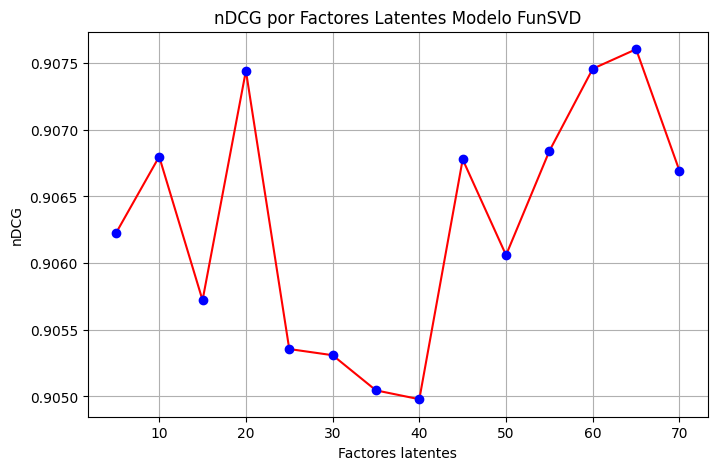

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(factores, ndcg_f, 'r-')
plt.plot(factores, ndcg_f, 'bo')
plt.xlabel('Factores latentes')
plt.ylabel('nDCG')
plt.title('nDCG por Factores Latentes Modelo FunSVD')
plt.grid(True)
plt.show()

In [35]:
ndcg_f

[0.9062229185899886,
 0.9067990275194976,
 0.9057212607323932,
 0.9074431056978076,
 0.9053552761551014,
 0.9053090339573551,
 0.9050452796185404,
 0.904978805780076,
 0.9067780563982965,
 0.9060599400343315,
 0.9068414457296609,
 0.9074582477385058,
 0.9076046875966226,
 0.9066925142253275]

**Conclusión**

Es interesante ver que el método FunkSVD, con 65 factores latentes, nos arroja un nDCG@10 = 0.9076. Este valor lo podemos comparar con los métodos ALS y BPR. Como vimos en el punto anterior, el nDCG@10 BPR = 0.82 y el nDCG@10 ALS = 0.904. Esto quiere decir, que los modelos FunkSVD y ALS tienen resultados muy similares.

Esto nos demuestra que el método ALS es muy poderoso, y muestra rendimientos muy similares a métodos de filtrado colaborativo como FunkSVD, que utiliza el feedback explícito, al menos para la métrica de nDCG@10.

Como ya habiamos visto en el punto anterior, el método BPR se queda un poco por detrás de los otros 2 métodos.